# Download Dataset from Kaggle

In [ ]:
!kaggle datasets download -d reemsalahshehab/dental-datasetv3

Dataset URL: https://www.kaggle.com/datasets/reemsalahshehab/dental-datasetv3
License(s): apache-2.0
 97% 217M/225M [00:02<00:00, 85.7MB/s]
100% 225M/225M [00:02<00:00, 79.4MB/s]


In [ ]:
!unzip dental-datasetv3.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/labels/3578770000-jpg_png_jpg.rf.783187fed2af4152fc369badba34020e.txt  
  inflating: train/labels/3578960000-jpg_png_jpg.rf.059d3a40e0ef928dcc250c7d339a2084.txt  
  inflating: train/labels/3579460000-jpg_png_jpg.rf.6997f950af4cf522fbae60d52d523147.txt  
  inflating: train/labels/3579600000-jpg_png_jpg.rf.04fc5c48ffedc1e3c407269bd0b76d5c.txt  
  inflating: train/labels/3579920000-jpg_png_jpg.rf.18e84641fc95bf381b5b63b06f6050fa.txt  
  inflating: train/labels/3581520000-jpg_png_jpg.rf.ca741f7ef63253d1000c21c631deff9f.txt  
  inflating: train/labels/3581550000-jpg_png_jpg.rf.da1c9b2612c50980610b366e91017bca.txt  
  inflating: train/labels/3581860000-jpg_png_jpg.rf.07b6186f5656f11b9074a21c2fabec75.txt  
  inflating: train/labels/3581870000-jpg_png_jpg.rf.87c6f9b4aee9ebd3b95c494db46c176e.txt  
  inflating: train/labels/3582190000-jpg_png_jpg.rf.9a5e93749cabee43ab9018a8e3b77652.txt  
  inflating: train/labels/3583580000-jp

# Saving Dataset for later use 

In [ ]:
import os
source_folder = 'dental-datasetv3'
destination_folder = '/content/drive/MyDrive/dental-datasetv3'

!cp -r "{source_folder}" "{destination_folder}"

# Imports Necessary Modules

In [3]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import os
import sys
import seaborn as sns
import pandas as pd
import torch
import random
from matplotlib.patches import Polygon
from pathlib import Path
import albumentations as A
from glob import glob
SEED = 42
np.random.seed(SEED)
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Paths

In [3]:
base_dir = '/content/drive/MyDrive/dental-datasetv3'
train_dir = f'{base_dir}/train'
valid_dir = f'{base_dir}/valid'
test_dir = f'{base_dir}/test'

# Dataset Distribution: Train Set

In [4]:
print("Train set:\n========================================")
print(f"{len(os.listdir(os.path.join(train_dir, 'images')))} images")
print(f"{len(os.listdir(os.path.join(train_dir, 'labels')))} labels")

Train set:
4174 images
4174 labels


# Dataset Distribution: Valid Set

In [5]:
print("Valid set:\n========================================")
print(f"{len(os.listdir(os.path.join(valid_dir, 'images')))} images")
print(f"{len(os.listdir(os.path.join(valid_dir, 'labels')))} labels")

Valid set:
812 images
812 labels


# Dataset Distribution: Test Set

In [6]:
print("Test set:\n========================================")
print(f"{len(os.listdir(os.path.join(test_dir, 'images')))} images")
print(f"{len(os.listdir(os.path.join(test_dir, 'labels')))} labels")

Test set:
557 images
557 labels


In [7]:
dataset_path = pathlib.Path('/content/drive/MyDrive/dental-datasetv3')
print("Files present in the Input Dataset")
print('\n'.join([str(files) for files in dataset_path.iterdir()]))


Files present in the Input Dataset
/content/drive/MyDrive/dental-datasetv3/train
/content/drive/MyDrive/dental-datasetv3/README.roboflow.txt
/content/drive/MyDrive/dental-datasetv3/README.dataset.txt
/content/drive/MyDrive/dental-datasetv3/test
/content/drive/MyDrive/dental-datasetv3/valid
/content/drive/MyDrive/dental-datasetv3/.ipynb_checkpoints
/content/drive/MyDrive/dental-datasetv3/cdataforreplacevalwithtest.yaml
/content/drive/MyDrive/dental-datasetv3/data.yaml


# Viewing YOLO Dataset Configuration (data.yaml)

In [8]:
file_path = '/content/drive/MyDrive/dental-datasetv3/data.yaml'
with open(file_path, 'r') as file:
    content = file.read()
    print(content)


train: '/content/drive/MyDrive/dental-datasetv3/train/images'
val: '/content/drive/MyDrive/dental-datasetv3/valid/images'
test: '/content/drive/MyDrive/dental-datasetv3/test/images'

nc: 10
names: ['Amalgam filling', 'Caries', 'Composite filling', 'Crown', 'Filling', 'Implant', 'Periapical lesion', 'Retained root', 'Root canal filling', 'Root canal obturation']



# Distribution of Images Across Train, Validation, and Test Sets

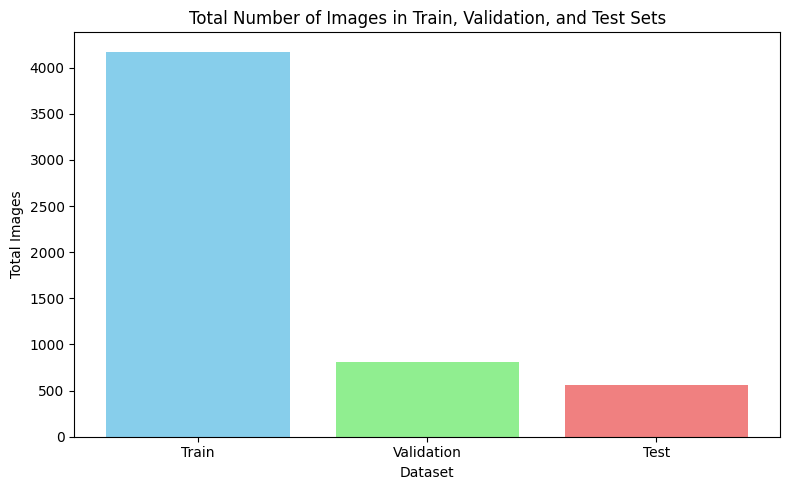

In [9]:
data_dirs = {
    "Train": "/content/drive/MyDrive/dental-datasetv3/train/images",
    "Validation": "/content/drive/MyDrive/dental-datasetv3/valid/images",
    "Test": "/content/drive/MyDrive/dental-datasetv3/test/images"
}
def count_total_images(images_dir):
    return len([img for img in os.listdir(images_dir) if img.endswith(('.jpg', '.png'))])

total_counts = {split: count_total_images(image_dir) for split, image_dir in data_dirs.items()}
plt.figure(figsize=(8, 5))
plt.bar(total_counts.keys(), total_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Dataset')
plt.ylabel('Total Images')
plt.title('Total Number of Images in Train, Validation, and Test Sets')
plt.tight_layout()
plt.show()

# Preprocessing and Augmentation Pipeline

In [ ]:
datasets = {
    "train": "/content/drive/MyDrive/dental-datasetv3/train/",
    "valid": "/content/drive/MyDrive/dental-datasetv3/valid/",
    "test": "/content/drive/MyDrive/dental-datasetv3/test/"
}

output_root = "/content/drive/MyDrive/data_after_agu/"

train_augmentations = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, p=0.5),
    A.GaussNoise(var_limit=(0.1,0.2), p=0.5)
])


resize_transform = A.Compose([
    A.Resize(640, 640),
])

def process_image(image_path, apply_augmentation=False):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if apply_augmentation:
        image = train_augmentations(image=image)["image"]


    image = resize_transform(image=image)["image"]

    return (image * 255).astype(np.uint8)

for split, dataset_path in datasets.items():
    image_folder = os.path.join(dataset_path, "images/")
    label_folder = os.path.join(dataset_path, "labels/")

    output_image_folder = os.path.join(output_root, split, "images/")
    output_label_folder = os.path.join(output_root, split, "labels/")

    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)

    for img_path in glob(os.path.join(image_folder, "*.jpg")):
        apply_augmentation = True if split == "train" else False
        processed_image = process_image(img_path, apply_augmentation)


        output_file = os.path.join(output_image_folder, os.path.basename(img_path))
        cv2.imwrite(output_file, processed_image)

        label_path = os.path.join(label_folder, os.path.basename(img_path).replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            output_label_path = os.path.join(output_label_folder, os.path.basename(label_path))
            os.system(f"cp {label_path} {output_label_path}")

    print(f"Processed {split} dataset and saved in {output_image_folder}")

print("All datasets are preprocessed and saved successfully")

Processed train dataset and saved in /content/drive/MyDrive/data_after_agu/train/images/
Processed valid dataset and saved in /content/drive/MyDrive/data_after_agu/valid/images/
Processed test dataset and saved in /content/drive/MyDrive/data_after_agu/test/images/
All datasets are preprocessed and saved successfully!


# Visualization of Annotated Teeth Detection Dataset

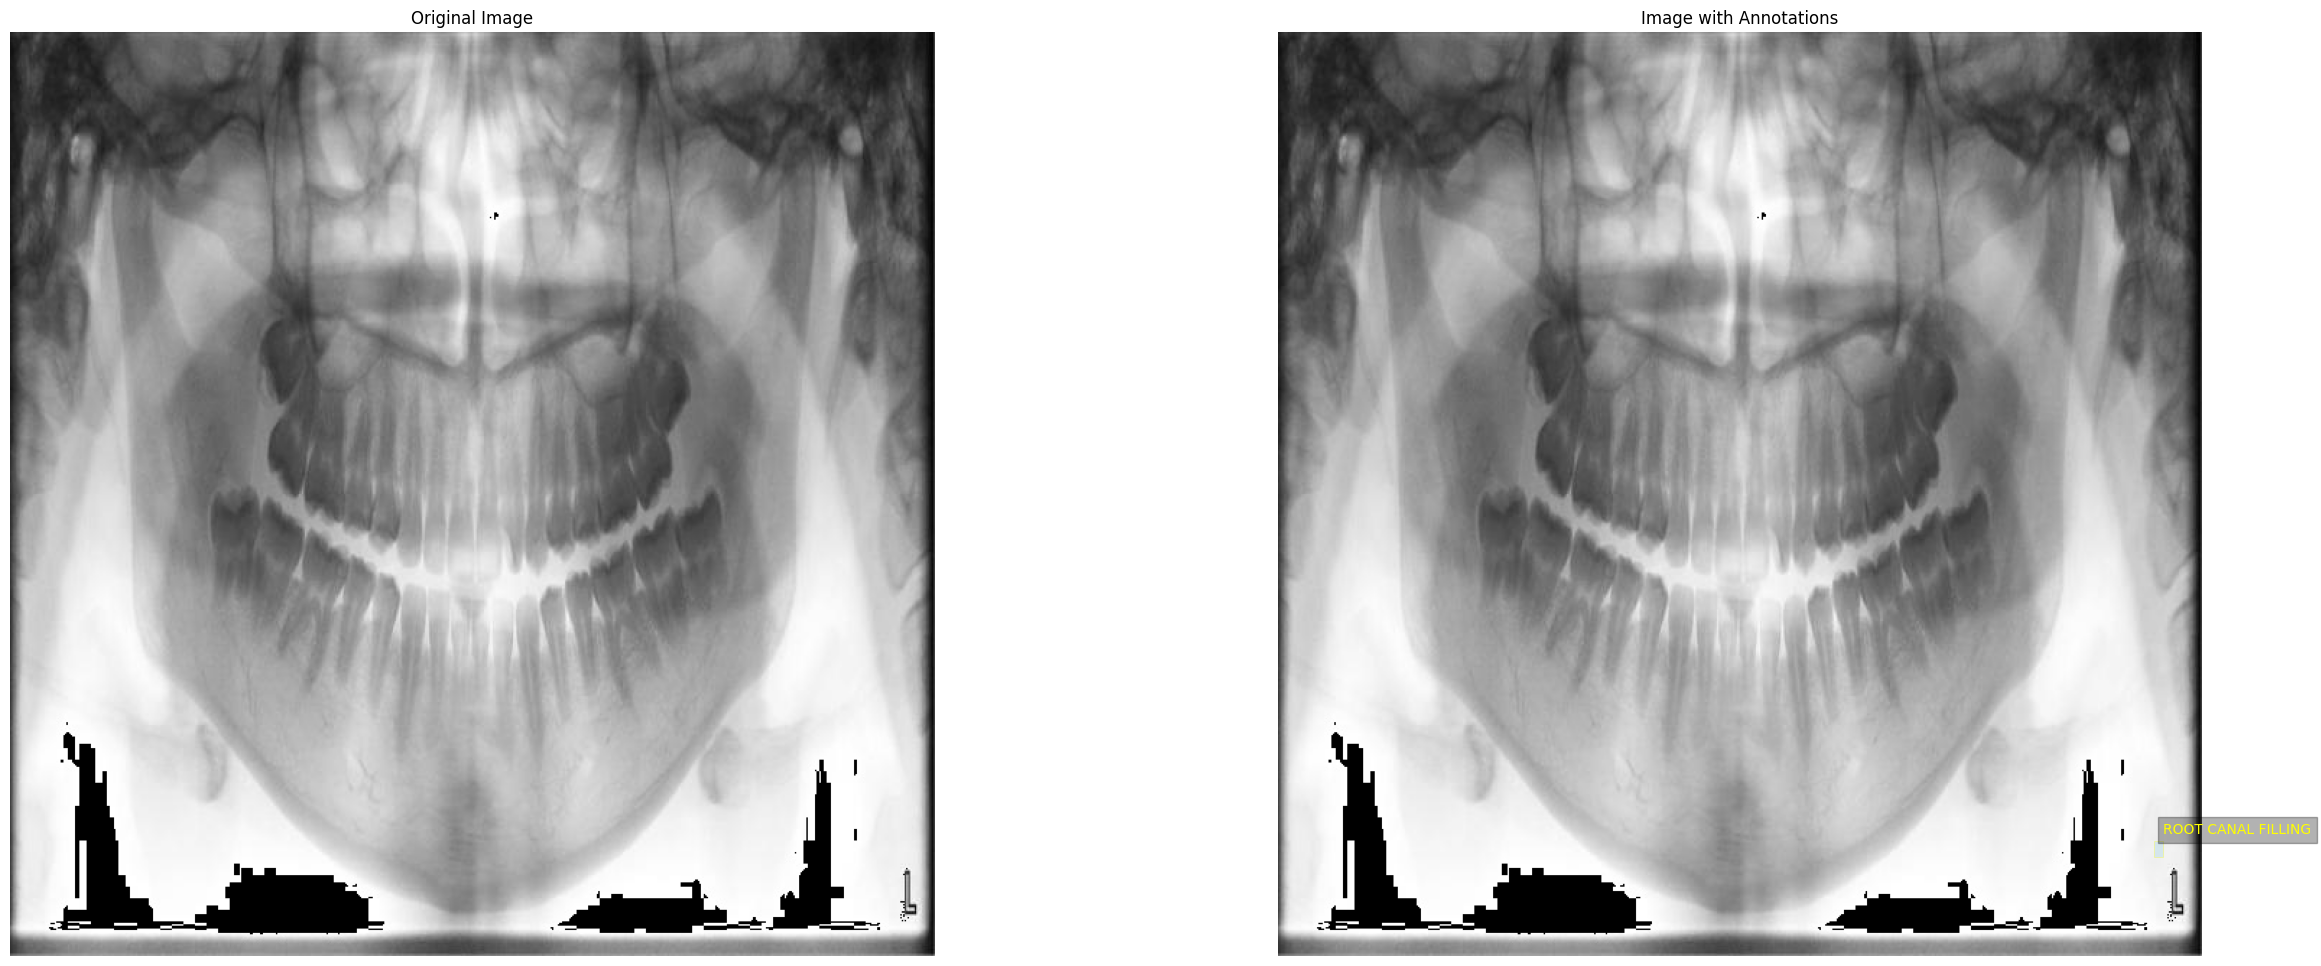

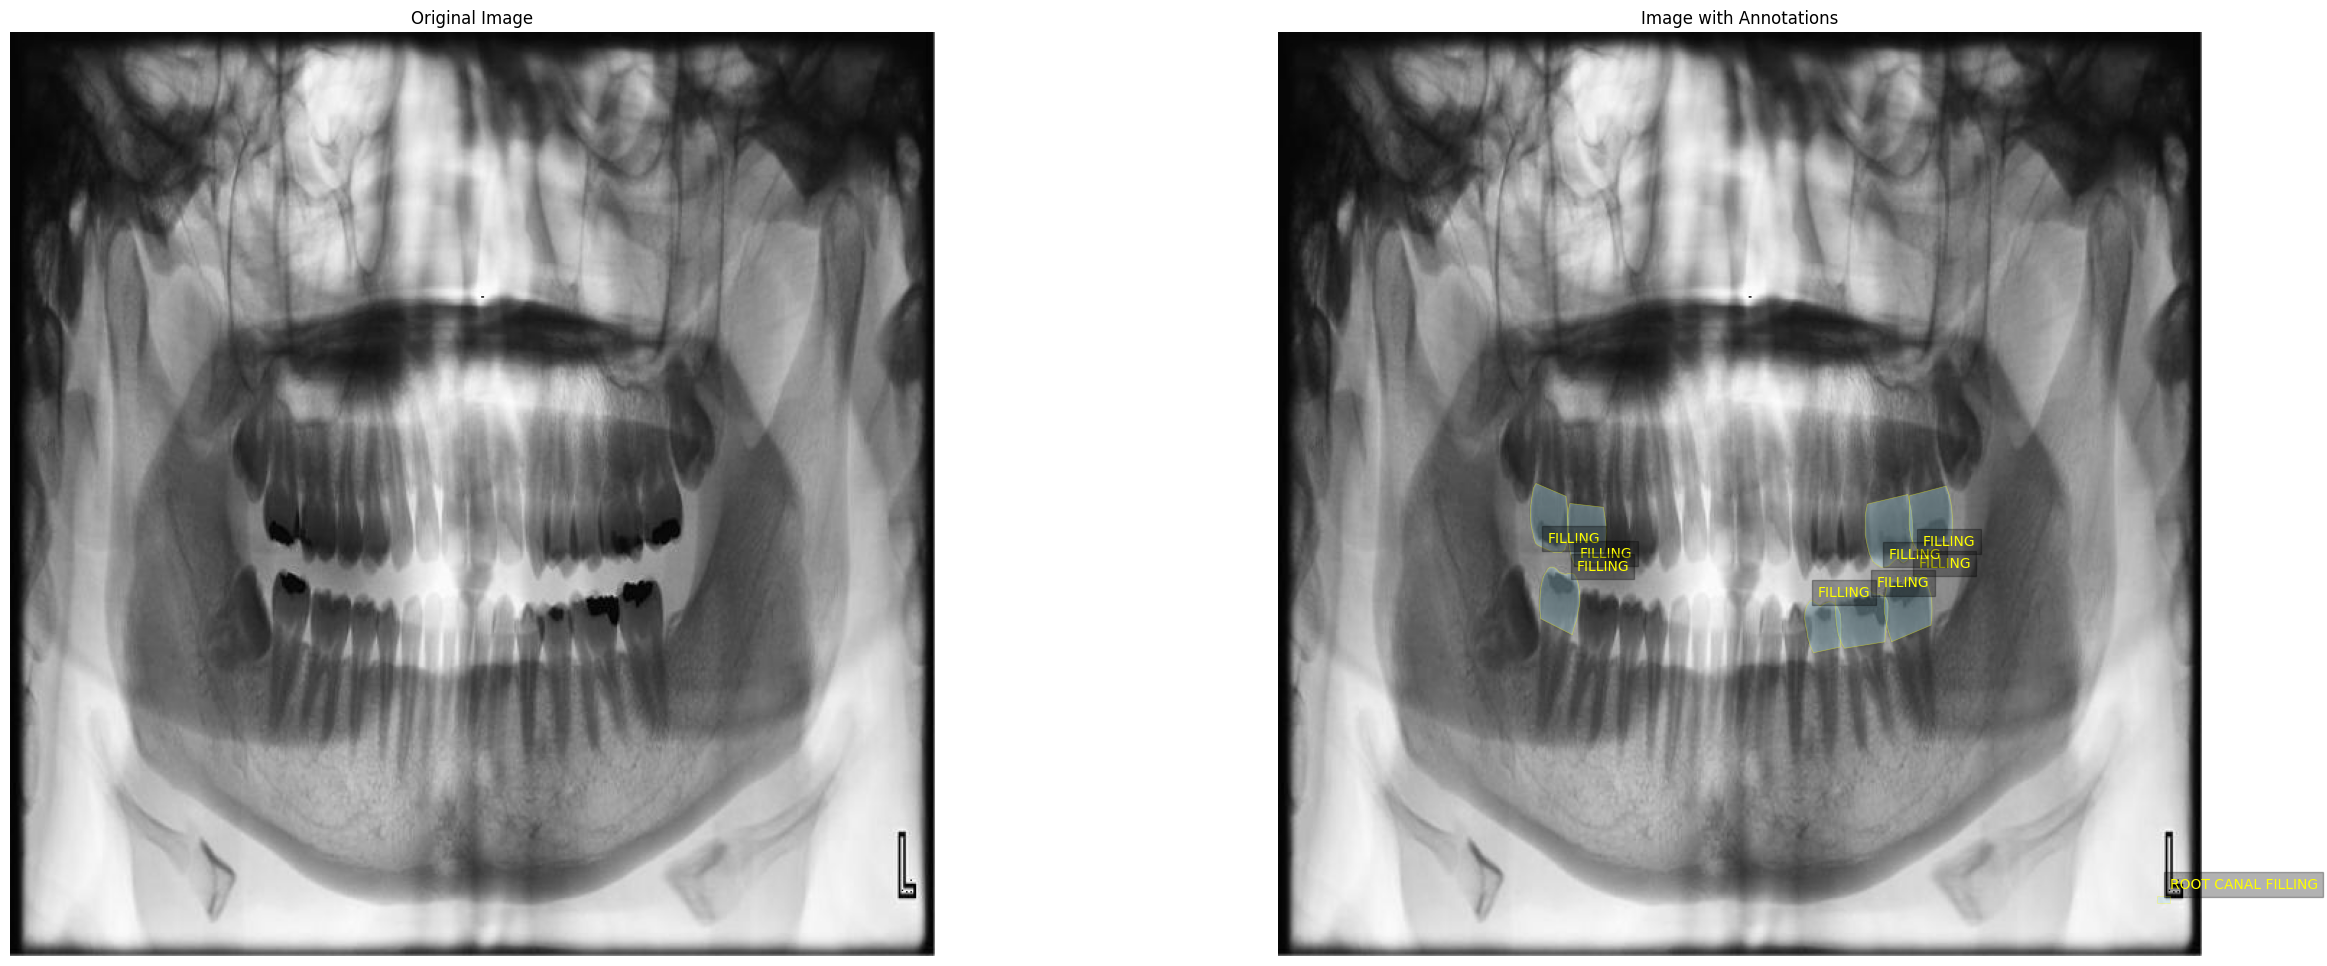

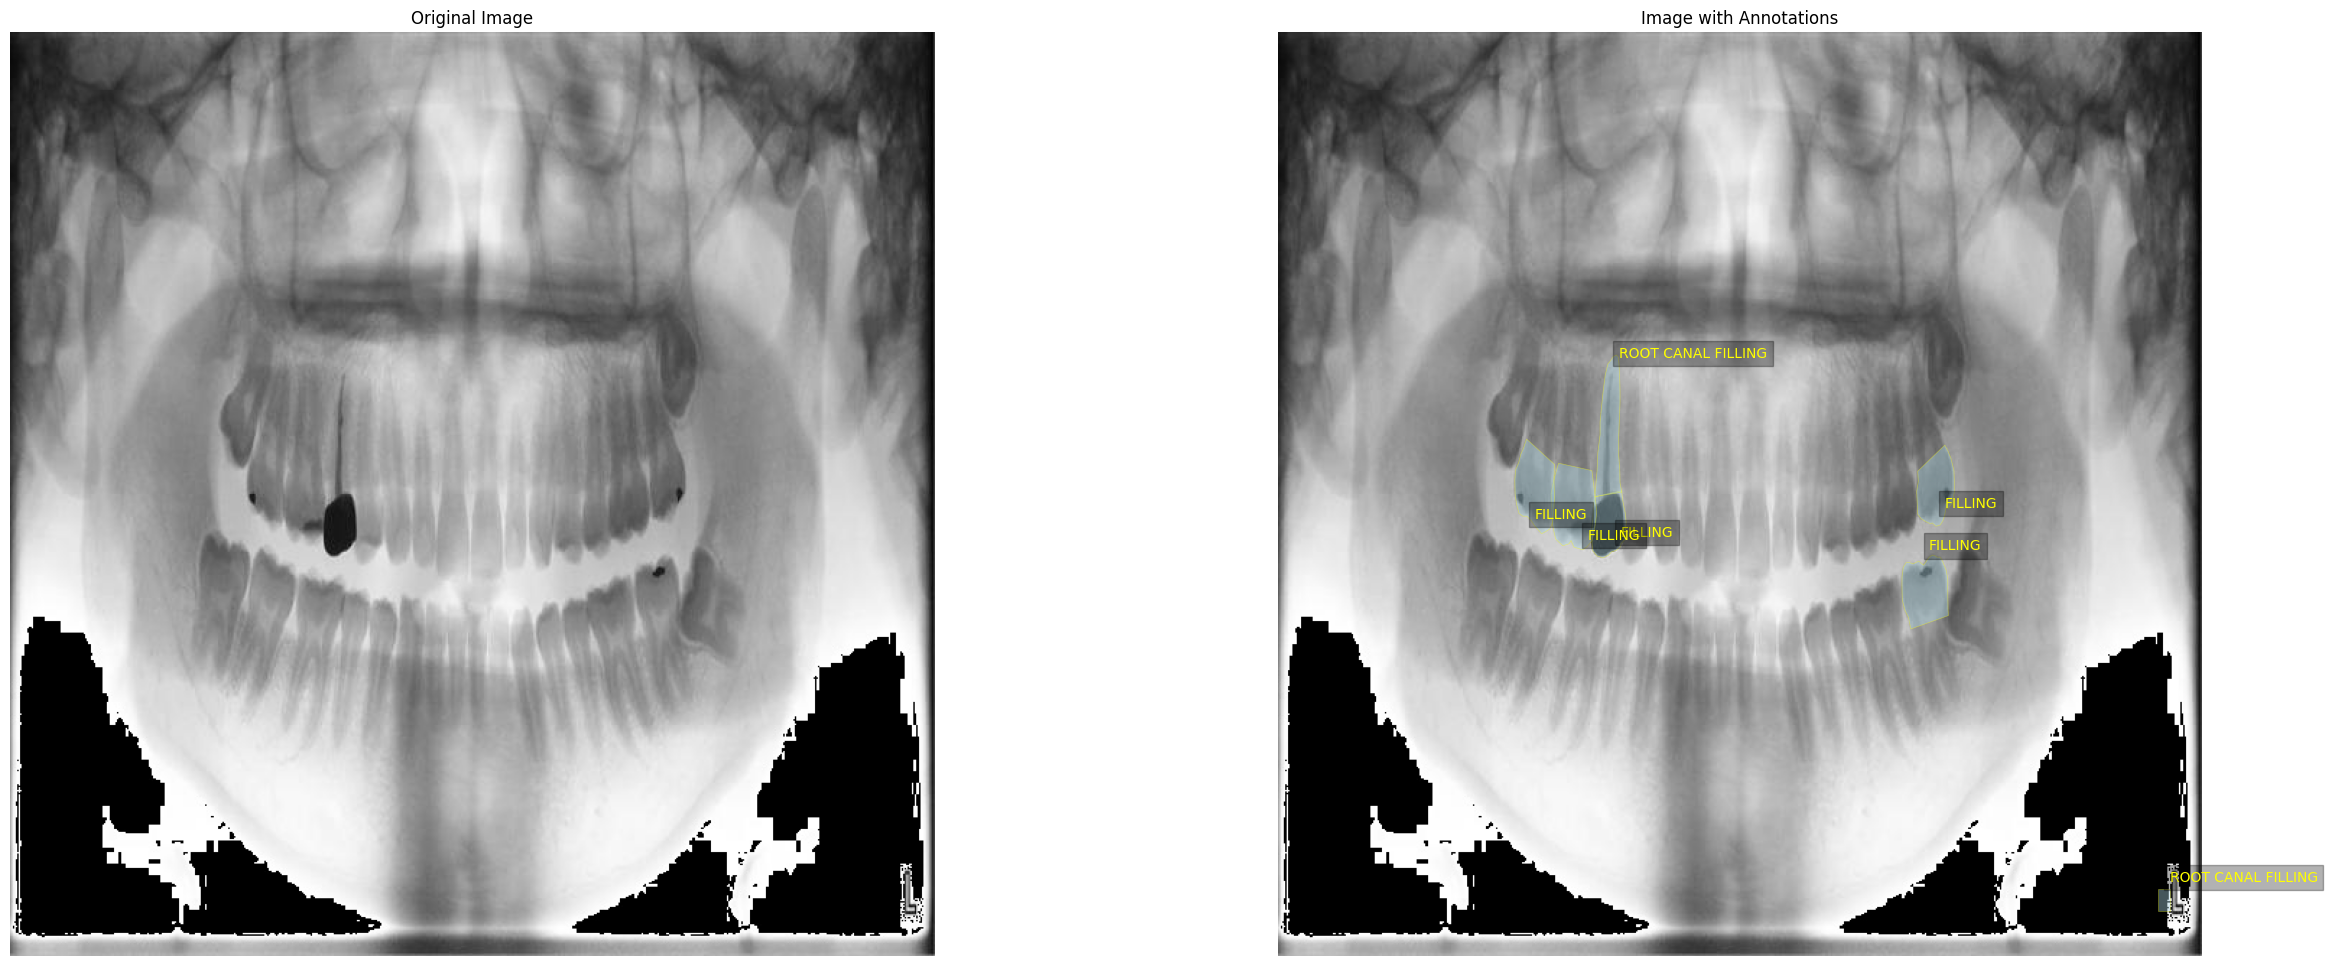

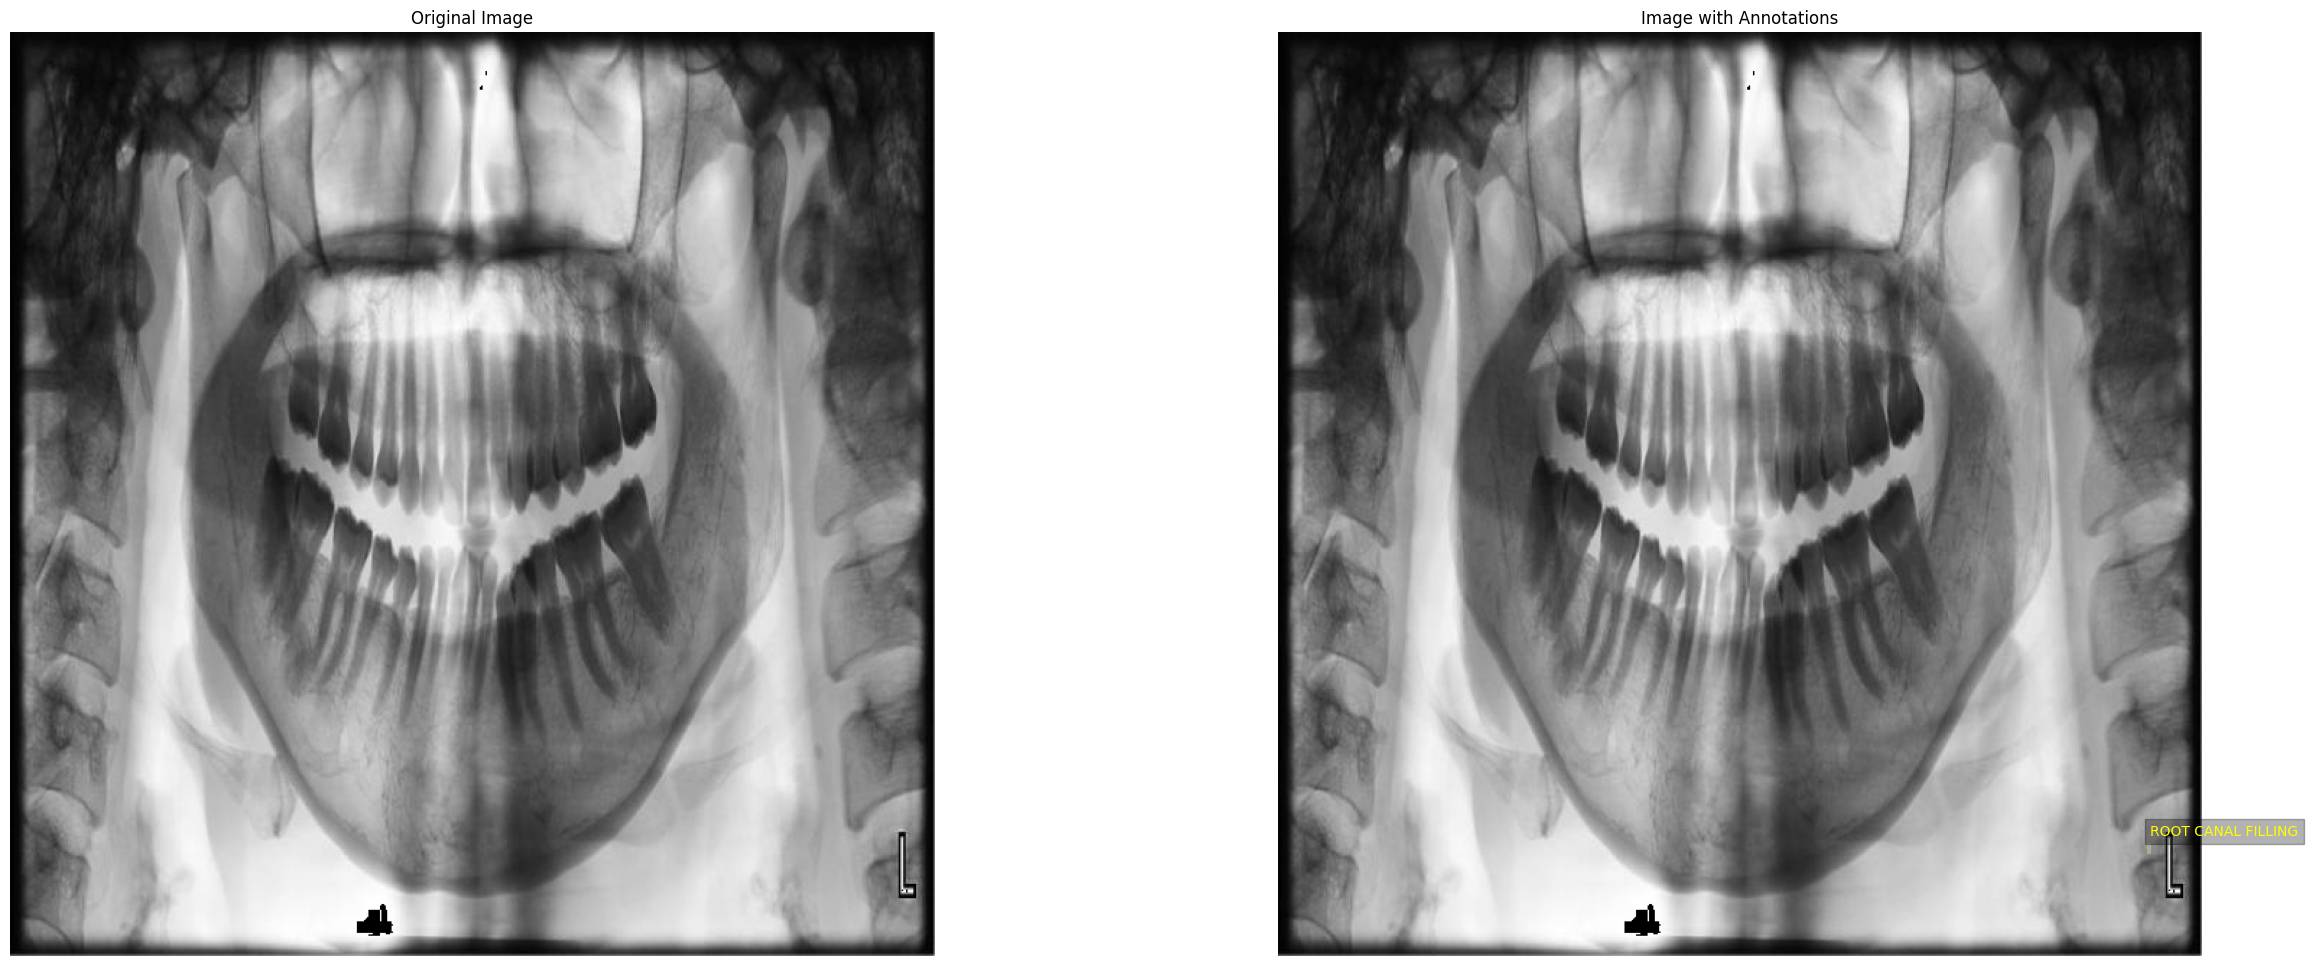

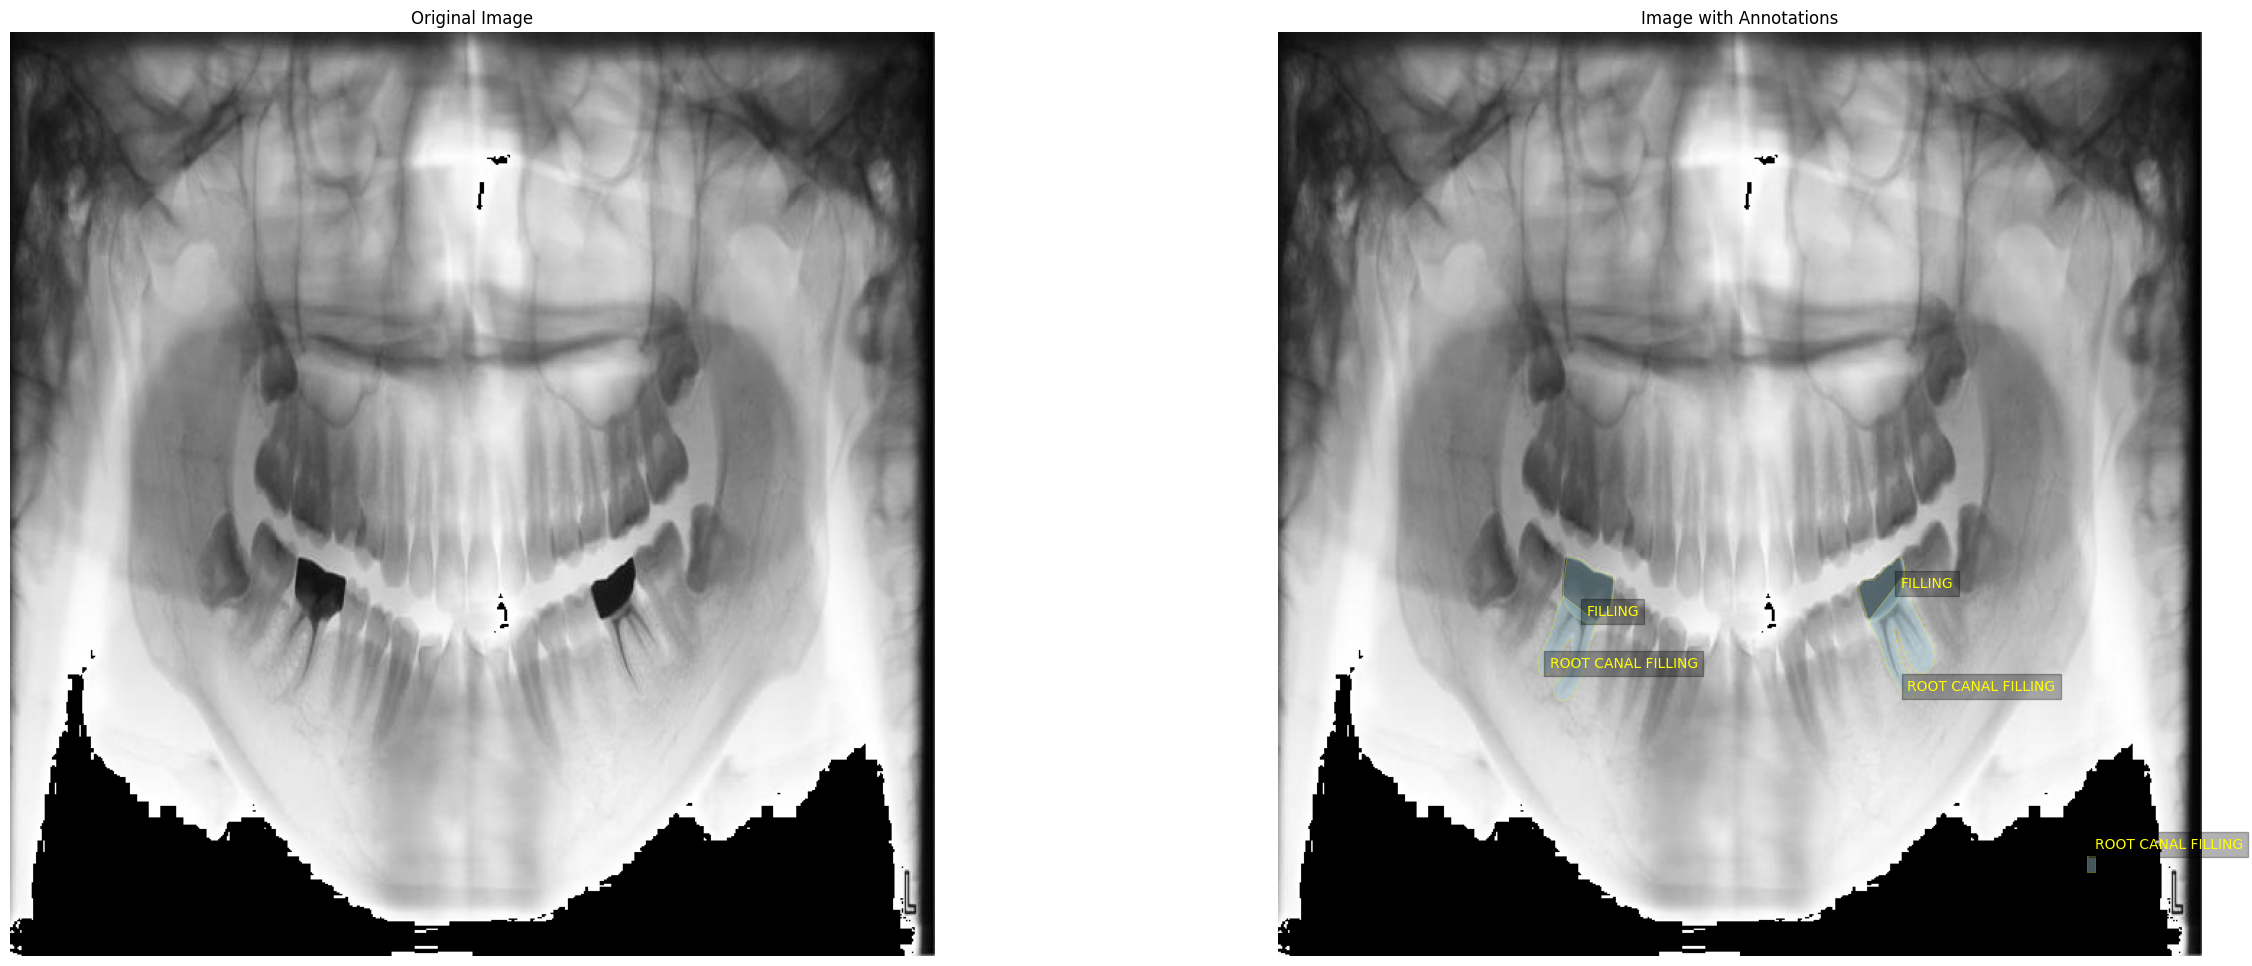

In [14]:
classes_names = [
    'Amalgam filling', 'Caries', 'Composite filling', 'Crown', 'Filling', 'Implant',
    'Periapical lesion', 'Retained root', 'Root canal filling', 'Root canal obturation'
]

def load_labels(label_path):
    with open(label_path, 'r') as label_file:
        label_lines = label_file.read().strip().split('\n')
        return [list(map(float, line.split())) for line in label_lines]

def plot_labels(ax, labels_data, img_w, img_h, color, classes):
    for label in labels_data:
        if len(label) < 2:
            continue

        class_id = int(label[0])
        points = label[1:]
        class_name = classes[class_id].upper()

        polygon_points = [(points[i] * img_w, points[i + 1] * img_h) for i in range(0, len(points) - 1, 2)]
        polygon = Polygon(polygon_points, closed=True, edgecolor=color, facecolor='lightblue', linewidth=0.5, alpha=0.4)
        ax.add_patch(polygon)

        x_min, y_min = polygon_points[0]
        ax.text(x_min, y_min - 5, class_name, color=color, fontsize=10, bbox=dict(facecolor='black', alpha=0.3))

def display_images(dataset_path, sample_size=5):
    dataset_path = Path(dataset_path)
    valid_path = dataset_path / 'valid'
    labels_dir = valid_path / 'labels'
    images_dir = valid_path / 'images'

    if not labels_dir.exists() or not images_dir.exists():
        print(f"Labels or images folder not found in {valid_path}")
        return

    image_files = list(images_dir.iterdir())
    if not image_files:
        print(f"No images found in {images_dir}")
        return

    random_sample = random.sample(image_files, min(sample_size, len(image_files)))

    for image_file in random_sample:
        image = cv2.imread(str(image_file.absolute()))
        if image is None:
            print(f"Failed to load image: {image_file}")
            continue

        label_files = list(labels_dir.glob(f'{image_file.stem}.*'))
        if not label_files:
            print(f"No label file found for image: {image_file}")
            continue

        labels_path = label_files[0]
        labels_data = load_labels(labels_path)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(1, 2, figsize=(30, 12))
        ax[0].imshow(image_rgb)
        ax[0].set_title("Original Image")
        ax[1].imshow(image_rgb)
        ax[1].set_title("Image with Annotations")

        img_h, img_w = image.shape[:2]
        plot_labels(ax[1], labels_data, img_w, img_h, 'yellow', classes_names)

        for a in ax:
            a.axis('off')
        plt.show()

display_images('/content/drive/MyDrive/data_after_agu', sample_size=5)


# YOLOv8 Model Initialization

In [5]:
#!pip install ultralytics -q
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('Runs', exist_ok=True)
sys.path.append('/content/drive/MyDrive/packages')
from ultralytics import YOLO

# Hyperparameters for YOLOv8-Seg Training

In [7]:
base_model = 'yolov8s-seg.pt'
BATCH_SIZE = 40
EPOCHS = 30
IMG_SIZE = 640
PROJECT_PATH = '/content/drive/MyDrive/project_path_v3_agu_yolo8_version2'
data_yaml = '/content/drive/MyDrive/data_after_agu/data.yaml'

# Fine-Tuning YOLOv8s-Seg on Teeth Detection Data

In [7]:
model = YOLO(base_model)
results = model.train(
    data=data_yaml,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=0,
    project=PROJECT_PATH,
    name='yolov8s_seg_run',
)

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/drive/MyDrive/data_after_agu/data.yaml, epochs=30, time=None, patience=100, batch=40, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/project_path_v3_agu_yolo8_version2, name=yolov8s_seg_run2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

train: Scanning /content/drive/MyDrive/data_after_agu/train/labels... 4174 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4174/4174 [01:22<00:00, 50.69it/s] 


train: New cache created: /content/drive/MyDrive/data_after_agu/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/data_after_agu/valid/labels... 812 images, 0 backgrounds, 0 corrupt: 100%|██████████| 812/812 [00:18<00:00, 44.36it/s] 


val: New cache created: /content/drive/MyDrive/data_after_agu/valid/labels.cache
Plotting labels to /content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.000625), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.6G      1.629      2.973      3.316      1.255        141        640: 100%|██████████| 105/105 [03:31<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


                   all        812       6030      0.434      0.314      0.202      0.116      0.428      0.296      0.188     0.0923

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.7G      1.323      2.358      1.174      1.098        189        640: 100%|██████████| 105/105 [03:18<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:22<00:00,  2.01s/it]


                   all        812       6030      0.615      0.369      0.373      0.218      0.571       0.37       0.33      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30        12G      1.292      2.267      1.073      1.079        132        640: 100%|██████████| 105/105 [03:25<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.87s/it]


                   all        812       6030      0.408      0.381      0.268      0.161      0.383      0.353      0.239      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      11.8G      1.262       2.21     0.9975      1.073        189        640: 100%|██████████| 105/105 [03:22<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


                   all        812       6030      0.637      0.539      0.553      0.337       0.62      0.522      0.527      0.279

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      11.8G      1.236      2.123     0.9555      1.065        191        640: 100%|██████████| 105/105 [03:23<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


                   all        812       6030      0.701      0.547      0.587      0.362      0.677       0.52       0.54      0.289

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.6G      1.218       2.08     0.9126      1.051        111        640: 100%|██████████| 105/105 [03:21<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.82s/it]


                   all        812       6030      0.692      0.553      0.562      0.343      0.642      0.527      0.519       0.27

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      11.7G      1.197      2.034     0.8836      1.041        130        640: 100%|██████████| 105/105 [03:21<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


                   all        812       6030      0.709      0.563      0.581      0.352        0.7      0.547      0.553      0.271

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.5G       1.19      2.037     0.8596      1.043        142        640: 100%|██████████| 105/105 [03:19<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


                   all        812       6030      0.789      0.595      0.648      0.406      0.754      0.573      0.605      0.322

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30        12G      1.174      1.972      0.852      1.031        156        640: 100%|██████████| 105/105 [03:19<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


                   all        812       6030      0.701      0.585      0.636      0.405      0.684      0.553      0.584       0.31

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      11.7G      1.165      1.975     0.8365      1.027        164        640: 100%|██████████| 105/105 [03:22<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]


                   all        812       6030      0.755      0.593      0.656      0.409      0.748      0.564      0.607      0.322

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30        12G      1.166      1.971     0.8229      1.026        186        640: 100%|██████████| 105/105 [03:21<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


                   all        812       6030       0.73      0.641      0.682      0.417      0.708      0.613      0.628       0.33

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      11.9G       1.16      1.923     0.8093      1.026        137        640: 100%|██████████| 105/105 [03:17<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


                   all        812       6030      0.668      0.628      0.633      0.405      0.637      0.609      0.589      0.304

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      11.7G      1.134      1.906     0.8047      1.019        191        640: 100%|██████████| 105/105 [03:19<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


                   all        812       6030      0.806      0.628      0.684      0.433      0.777      0.603       0.64      0.342

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      11.7G      1.126      1.862     0.7842      1.012        121        640: 100%|██████████| 105/105 [03:23<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


                   all        812       6030      0.747      0.643       0.69       0.44       0.71      0.616      0.647      0.342

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      11.9G      1.135      1.885     0.7886      1.008        172        640: 100%|██████████| 105/105 [03:22<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]


                   all        812       6030      0.798      0.665      0.707      0.452      0.761      0.623      0.651      0.343

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.7G      1.118      1.858     0.7721      1.011         91        640: 100%|██████████| 105/105 [03:23<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:23<00:00,  2.16s/it]


                   all        812       6030      0.704       0.64      0.638       0.41      0.689      0.606      0.596      0.314

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.2G      1.125      1.858     0.7666      1.009        104        640: 100%|██████████| 105/105 [03:24<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


                   all        812       6030      0.733      0.657      0.698      0.436      0.698      0.631      0.653      0.357

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30      11.9G      1.104      1.815     0.7501     0.9988        154        640: 100%|██████████| 105/105 [03:25<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


                   all        812       6030      0.838      0.658      0.725      0.465      0.819      0.632      0.683      0.375

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.5G      1.107      1.825     0.7402      1.006        159        640: 100%|██████████| 105/105 [03:25<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


                   all        812       6030      0.788      0.674      0.721      0.468      0.776      0.645      0.684      0.364

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30        12G      1.095      1.804     0.7412     0.9951        141        640: 100%|██████████| 105/105 [03:20<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


                   all        812       6030      0.806      0.663       0.73       0.47      0.774      0.638      0.684      0.372
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      11.8G       1.07      1.792     0.7169      1.048         86        640: 100%|██████████| 105/105 [02:20<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]

                   all        812       6030      0.786      0.683      0.733      0.473      0.776      0.653       0.69      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      11.6G      1.058      1.767     0.6993      1.043        141        640: 100%|██████████| 105/105 [02:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]

                   all        812       6030      0.788       0.68       0.72      0.468       0.76      0.651      0.681      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      11.6G      1.049      1.743     0.6843      1.039        101        640: 100%|██████████| 105/105 [02:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


                   all        812       6030      0.804      0.704      0.741      0.481      0.764      0.672      0.695      0.373

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      11.7G      1.036      1.719     0.6748      1.034         98        640: 100%|██████████| 105/105 [02:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


                   all        812       6030      0.831      0.694      0.748      0.487      0.798      0.661      0.696      0.376

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      11.8G      1.033      1.724     0.6679      1.035        140        640: 100%|██████████| 105/105 [02:14<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


                   all        812       6030      0.824      0.693      0.744      0.477      0.791      0.665      0.699      0.381

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      11.9G      1.027      1.697     0.6571      1.031        160        640: 100%|██████████| 105/105 [02:14<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.88s/it]


                   all        812       6030      0.816      0.708      0.749       0.49      0.786      0.679      0.701      0.388

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      11.7G      1.015      1.695     0.6472      1.025        104        640: 100%|██████████| 105/105 [02:15<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:22<00:00,  2.01s/it]


                   all        812       6030      0.824      0.711      0.748      0.488        0.8      0.664      0.702      0.379

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      11.7G      1.013      1.679     0.6444      1.026        145        640: 100%|██████████| 105/105 [02:15<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


                   all        812       6030      0.836      0.712      0.761      0.495      0.793      0.676      0.708      0.388

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      11.6G      1.006      1.659     0.6348      1.017         79        640: 100%|██████████| 105/105 [02:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:21<00:00,  1.94s/it]


                   all        812       6030      0.837       0.71       0.76      0.496      0.794      0.667      0.711      0.395

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      11.9G     0.9983      1.649     0.6311       1.02         78        640: 100%|██████████| 105/105 [02:15<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.91s/it]

                   all        812       6030      0.834       0.71      0.761      0.497      0.821      0.659      0.711       0.39



30 epochs completed in 1.695 hours.
Optimizer stripped from /content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/weights/last.pt, 23.9MB
Optimizer stripped from /content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/weights/best.pt, 23.9MB

Validating /content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,783,470 parameters, 0 gradients, 42.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:34<00:00,  3.13s/it]


                   all        812       6030      0.836      0.711       0.76      0.496      0.795      0.668      0.711      0.396
       Amalgam filling         61        278       0.91      0.911      0.951      0.739      0.908      0.899      0.949      0.587
                Caries         78        528       0.76      0.275      0.406      0.163      0.676      0.233      0.343      0.128
     Composite filling         46        168      0.758       0.75      0.796       0.42      0.647      0.612       0.64      0.265
                 Crown         25        111      0.965      0.981       0.99      0.755       0.92      0.935      0.932      0.565
               Filling        580       3370       0.82      0.835      0.869      0.651      0.821       0.83      0.863      0.552
               Implant          2          6      0.876          1      0.995      0.757      0.879          1      0.995      0.721
         Retained root         18         48      0.808      0.583   

# YOLOv8 Model Evaluation

In [8]:
model = YOLO('/content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/weights/best.pt')

results = model.val(
    data='/content/drive/MyDrive/data_after_agu/data.yaml',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=0,
    save=True,
    save_txt=True
)

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,783,470 parameters, 0 gradients, 42.5 GFLOPs


val: Scanning /content/drive/MyDrive/data_after_agu/valid/labels.cache... 812 images, 0 backgrounds, 0 corrupt: 100%|██████████| 812/812 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:21<00:00,  9.61s/it]


                   all        812       6030      0.838       0.71      0.761      0.498      0.826      0.663       0.71      0.377
       Amalgam filling         61        278      0.913      0.911      0.954      0.744      0.936       0.91       0.96      0.604
                Caries         78        528      0.769      0.277      0.408      0.164      0.766      0.223       0.34      0.116
     Composite filling         46        168      0.759       0.75      0.796      0.424       0.76      0.673      0.742      0.303
                 Crown         25        111      0.965      0.981       0.99       0.75       0.92      0.931      0.932      0.559
               Filling        580       3370       0.82      0.836      0.869      0.653      0.837      0.815      0.864       0.56
               Implant          2          6      0.876          1      0.995      0.757      0.891          1      0.995      0.627
         Retained root         18         48      0.806      0.583   

# Performance Metrics Visualization

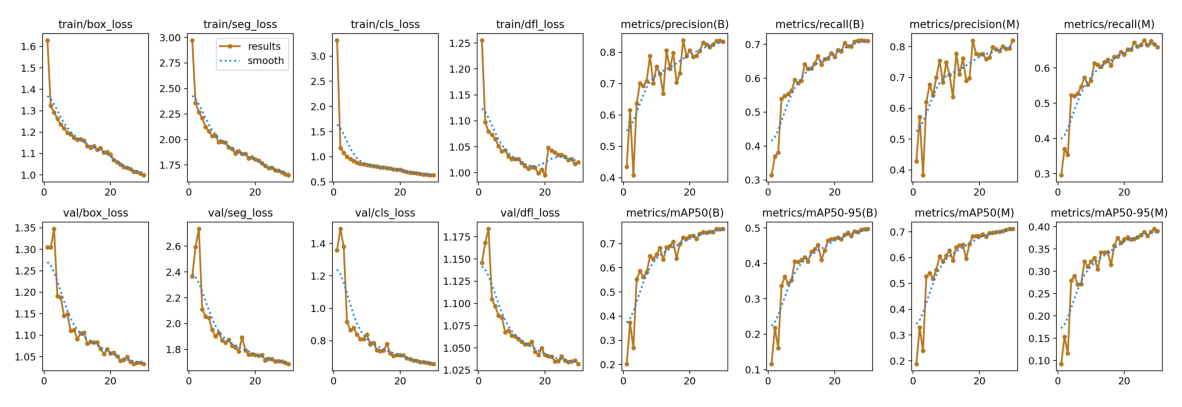

In [9]:
path = '/content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/results.png'

confusion_matrix = cv2.imread(path)
plt.figure(figsize=(15, 15))
plt.imshow(confusion_matrix)
plt.axis('off')
plt.show()

# Training Performance Metrics: Bounding Box & Mask Evaluations Over Epochs

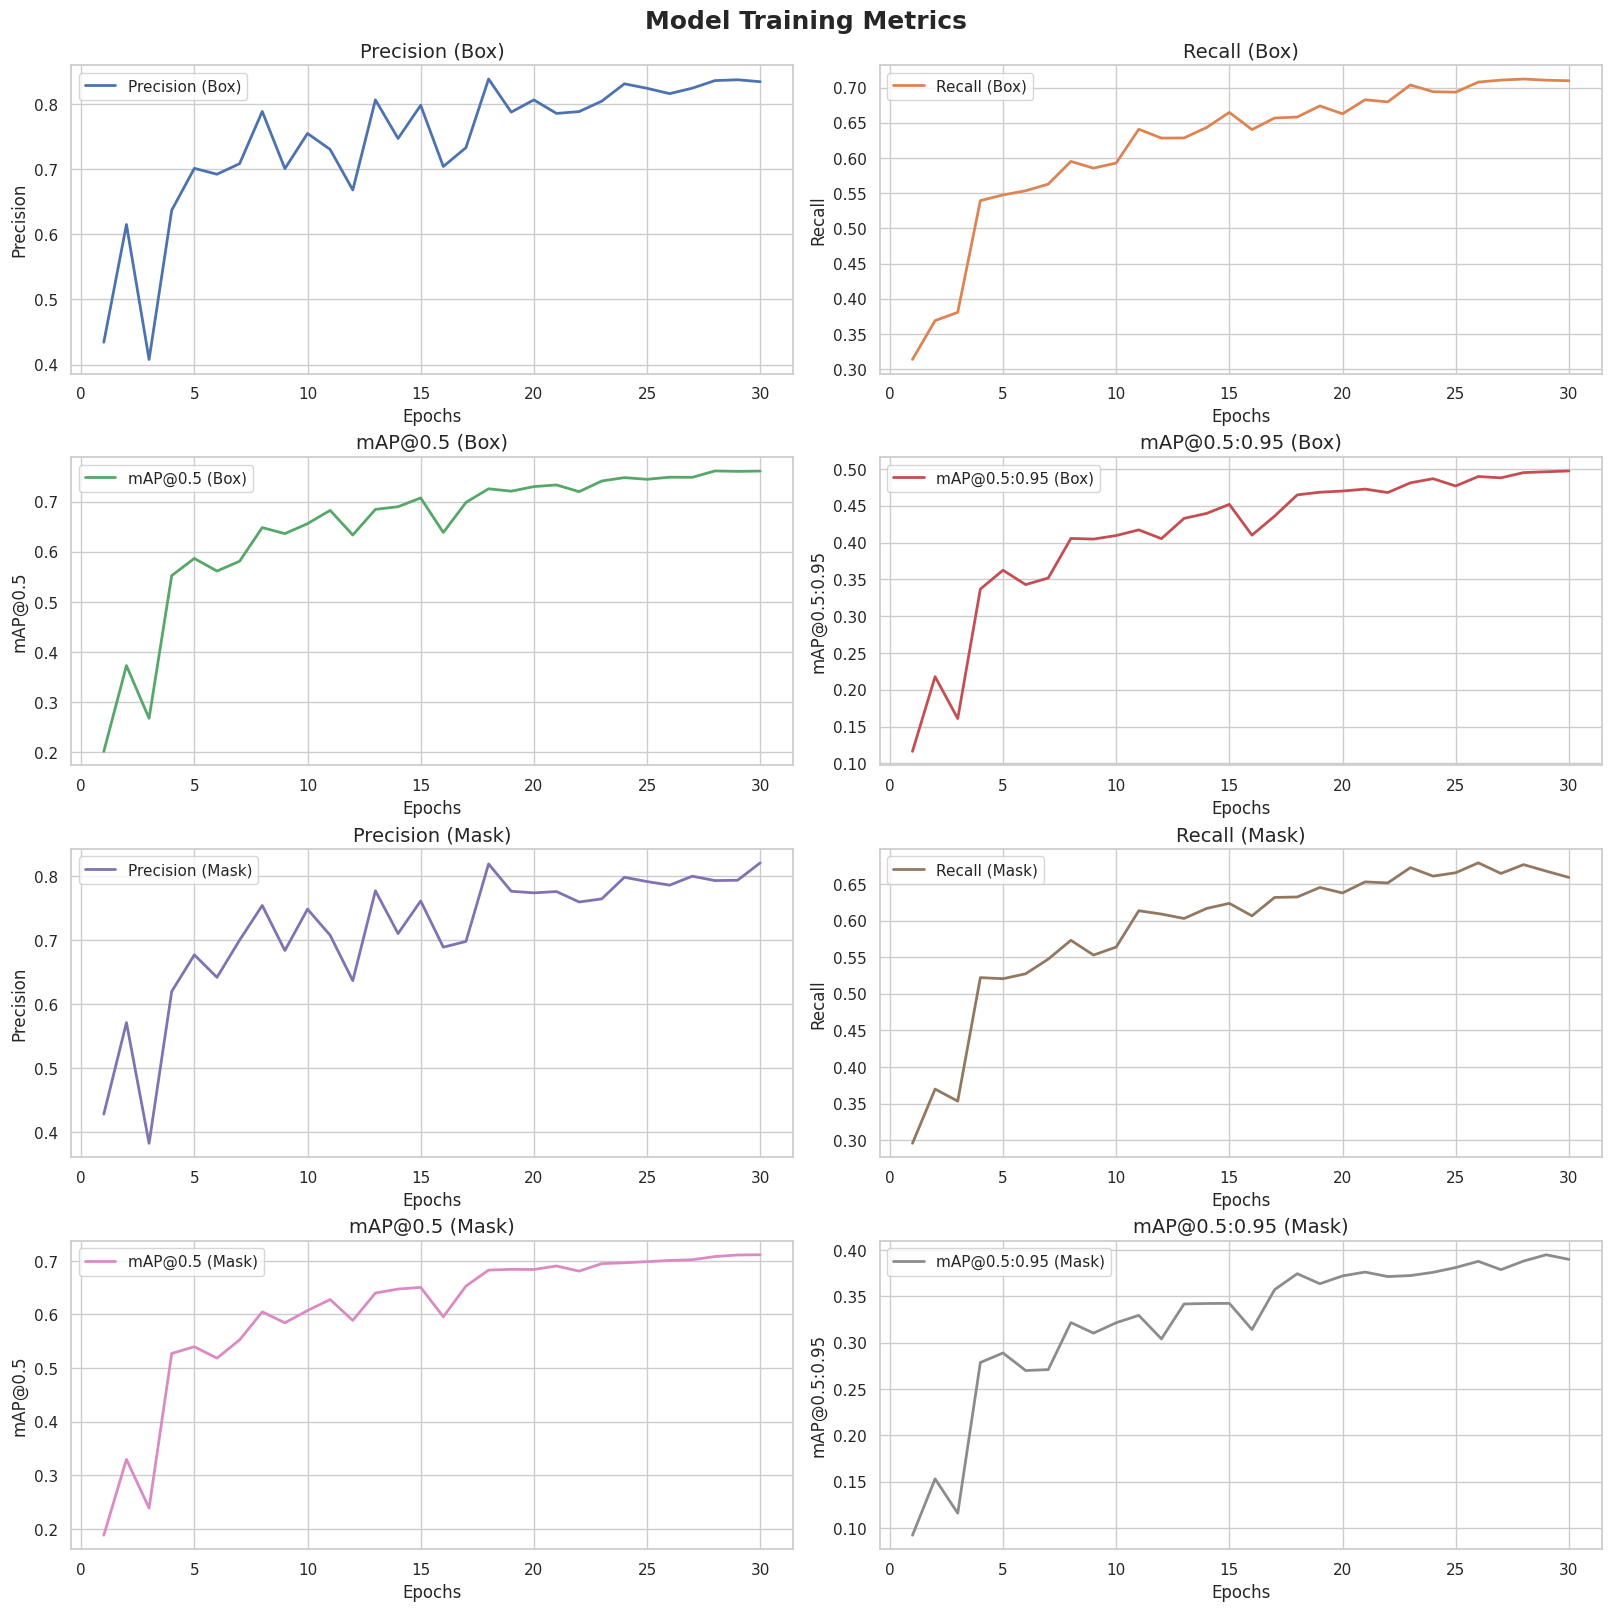

In [10]:
def visualize_metrics(file_path, train=True):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()

    sns.set_theme(style="whitegrid")
    metrics = {
        "Precision (Box)": "metrics/precision(B)",
        "Recall (Box)": "metrics/recall(B)",
        "mAP@0.5 (Box)": "metrics/mAP50(B)",
        "mAP@0.5:0.95 (Box)": "metrics/mAP50-95(B)",
        "Precision (Mask)": "metrics/precision(M)",
        "Recall (Mask)": "metrics/recall(M)",
        "mAP@0.5 (Mask)": "metrics/mAP50(M)",
        "mAP@0.5:0.95 (Mask)": "metrics/mAP50-95(M)"
    }

    fig, axes = plt.subplots(4, 2, figsize=(16, 16), constrained_layout=True)
    fig.suptitle("Model Training Metrics", fontsize=18, fontweight="bold")

    for idx, (metric_name, column) in enumerate(metrics.items()):
        if column in data.columns:
            ax = axes[idx // 2, idx % 2]
            ax.plot(data['epoch'], data[column], label=metric_name, color=sns.color_palette()[idx % len(sns.color_palette())], linewidth=2)
            ax.set_title(metric_name, fontsize=14)
            ax.set_xlabel("Epochs", fontsize=12)
            ax.set_ylabel(metric_name.split()[0], fontsize=12)
            ax.legend()


    plt.show()
visualize_metrics("/content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/results.csv")


# Load Trained Model and Predict on Test Image


image 1/1 /content/drive/MyDrive/data_after_agu/test/images/045b3b84-PIRI_NAJME_2020-02-18184406_jpg.rf.bf421a50d6e29e444533c98e7e0537d4.jpg: 640x640 2 Amalgam fillings, 5 Cariess, 2 Composite fillings, 23.1ms
Speed: 3.0ms preprocess, 23.1ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict4
1 label saved to runs/segment/predict4/labels


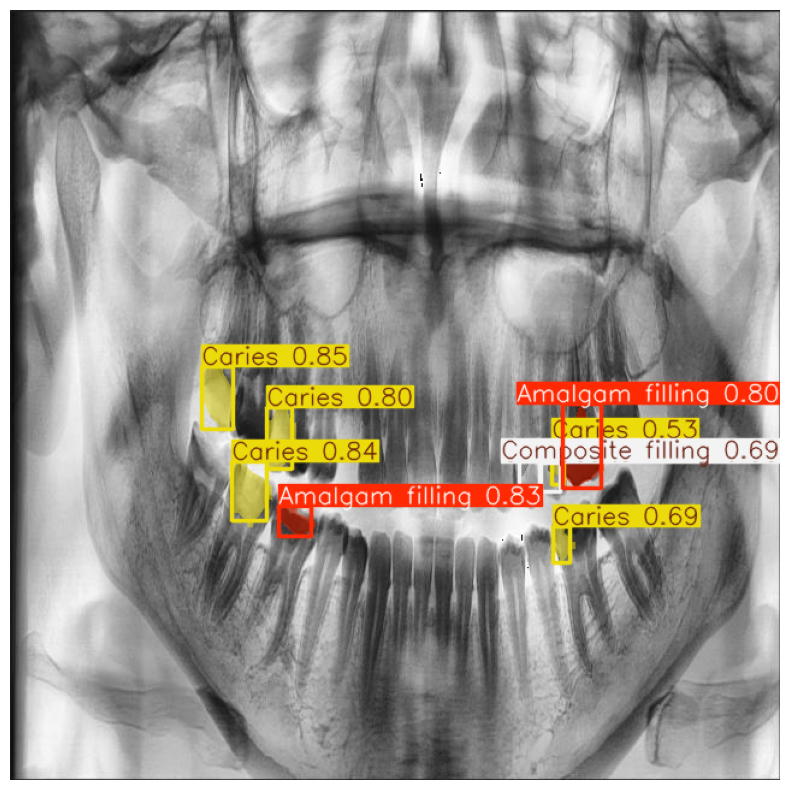

In [14]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

model = YOLO('/content/drive/MyDrive/project_path_v3_agu_yolo8_version2/yolov8s_seg_run2/weights/best.pt')

image_path = '/content/drive/MyDrive/data_after_agu/test/images/045b3b84-PIRI_NAJME_2020-02-18184406_jpg.rf.bf421a50d6e29e444533c98e7e0537d4.jpg'

results = model.predict(source=image_path, imgsz=640, conf=0.5, iou=0.5, save=True,save_txt=True)

for result in results:
    plotted_image = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(plotted_image)
    plt.axis('off')
    plt.show()